**Imports**

In [0]:
# Importing modules
import pandas as pd
import os
import re
import nltk
import random
nltk.download('words')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation as LDA

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


**Read sample reviews**

In [0]:

reviews = pd.read_csv('reviews_sample_Las_Vegas.csv')
reviews.head(5)

,business_id,name,city,state,postal_code,latitude,longitude,review_id,user_id,stars,date,text,useful,funny,cool,year
0,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Las Vegas,NV,89119,36.066914,-115.170848,aG4aEOW86hut943oqL_DOg,9kV4tmBcE-l5tJqzgKjZRA,4,2017-03-27,"Nice, open bar with great views of the strip a...",0,0,1,2017
1,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Las Vegas,NV,89119,36.066914,-115.170848,fQpivmd02GA4eZJRZGgDQQ,i7Z7iiDSbWq-npAYHQUeew,5,2016-08-27,We usually stop here after using the driving r...,0,0,0,2016
2,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Las Vegas,NV,89119,36.066914,-115.170848,3recIhisA9vC4wnQOMCj7g,7Iga45IMB_VKyPZnbhSE2w,1,2016-01-09,The first time we ate here everything was good...,1,1,0,2016
3,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Las Vegas,NV,89119,36.066914,-115.170848,18i3YtCuEGMxYSS7fQdR8Q,IvBzaJeCcuChLuKGq3xhxA,2,2016-08-22,So I took my daughter there for breakfast and ...,1,0,0,2016
4,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Las Vegas,NV,89119,36.066914,-115.170848,nNUaNk8s0elCDn6vjnpqSw,bZnjSVQApjVHrAV9jjtH_A,4,2016-10-29,"Happy hours 3-5pm. Beer started $3, buffalo wi...",2,0,3,2016


In [0]:
reviews.shape

(87060, 16)

**Look at distribution of review rating**



In [0]:
reviews['stars'].value_counts().sort_index()

1    10903
2     6940
3     9218
4    18093
5    41906
Name: stars, dtype: int64

**Plot the distribution**

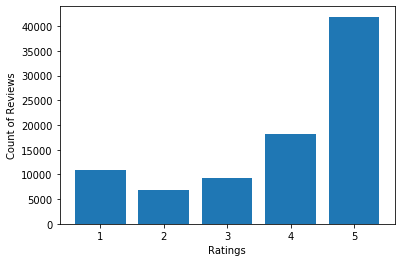

In [0]:
x = reviews['stars'].value_counts().sort_index().index
y = reviews['stars'].value_counts().sort_index().values
fig, ax = plt.subplots()
plt.bar(x, y)
plt.xlabel('Ratings')
plt.ylabel('Count of Reviews')
plt.show()

**Text cleaning**

In [0]:
words = set(nltk.corpus.words.words())
def keep_english_words(sentence):
  return " ".join(w for w in nltk.wordpunct_tokenize(sentence) \
                  if w.lower() in words or not w.isalpha())

reviews['text_processed'] = reviews['text'].map(lambda x: re.sub('[,\.!?\\n]', '', x))
reviews['text_processed'] = reviews['text_processed'].map(lambda x: x.lower())
reviews['text_processed'] = reviews['text_processed'].map(lambda x: keep_english_words(x))
# ?replace numbers with price

# Print out the first rows of papers
reviews['text_processed'].head(5)

0    nice open bar with great of the strip and golf...
1    we usually stop here after the driving range t...
2    the first time we ate here everything was good...
3    so i took my daughter there for breakfast and ...
4    happy 3 - 5pm beer $ 3 buffalo with vegetable ...
Name: text_processed, dtype: object

**Word Cloud**

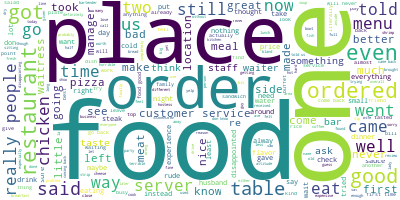

In [0]:
from wordcloud import WordCloud

negative_reviews = reviews[reviews['stars'] <= 2].reset_index(drop = True)

long_string = ','.join(list(negative_reviews['text_processed'] .values))
wordcloud = WordCloud(background_color="white", 
                      max_words=5000, 
                      contour_width=3, 
                      contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()


**Helper Function**

In [0]:
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

**Fit LDA model**

In [0]:
# Initialise the count vectorizer with the English stop words
n_features = 1000
n_samples = len(negative_reviews)
count_vectorizer = CountVectorizer(max_df=0.95, min_df=10,
                                max_features=n_features,
                                stop_words='english')

count_data = count_vectorizer.fit_transform(negative_reviews['text_processed'])

def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

number_topics = 5
number_words = 10

lda = LDA(n_components = number_topics,
          learning_method = 'batch',
          learning_decay = 0.7,
          max_iter = 5,
          verbose = 1,
          random_state = 0,
          n_jobs=-1)

print("Fitting LDA models with tf features, "
      "n_samples = %d and n_features = %d..."
      % (n_samples, n_features))

lda.fit(count_data)

print_topics(lda, count_vectorizer, number_words)


Fitting LDA models with tf features, n_samples = 17843 and n_features = 1000...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5

Topic #0:
food order service just place came got took ordered time

Topic #1:
food place good service like steak chicken just ordered better

Topic #2:
order service food time manager location said just ordered customer

Topic #3:
food like good ordered just place pizza chicken cheese rice

Topic #4:
time food table just service place people like restaurant wait


**Visualize the topics-keywords distribution.**

In [0]:
# !pip install pyLDAvis
import pyLDAvis.sklearn
vis_data = pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer)
pyLDAvis.display(vis_data)


/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


**Fit NMF Model**

In [0]:
n_features = 1000
n_samples = len(negative_reviews)
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=10,
                                   
                                   max_features=n_features,
                                   stop_words='english')

tfidf_data = tfidf_vectorizer.fit_transform(negative_reviews['text_processed'])
number_topics = 5
number_words = 10

nmf = NMF(n_components=number_topics, 
          random_state=1,
          alpha=.1, 
          l1_ratio=.5)

nmf.fit(tfidf_data)

print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
print_topics(nmf, tfidf_vectorizer, number_words)

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=17843 and n_features=1000...

Topic #0:
came table time server said just told wait manager people

Topic #1:
chicken like ordered good sauce rice taste just tasted meat

Topic #2:
pizza slice cheese crust pepperoni delivery good sauce ordered place

Topic #3:
food service good place bad horrible great customer terrible worst

Topic #4:
order wrong location drive got time customer took said phone


**Normalize Topic weights and merge to original data**

In [0]:
from sklearn.preprocessing import normalize

nmf_output = nmf.transform(tfidf_data)
topic_df = pd.DataFrame(normalize(nmf_output, norm='l1'), \
                                             columns = ['Topic 0', 'Topic 1',\
                                                        'Topic 2', 'Topic 3',\
                                                        'Topic 4'])
negative_reviews_f = pd.concat([negative_reviews, topic_df], axis=1)


**Look at random examples from each topic to make sense of the topics**

In [0]:
negative_reviews_f.columns

Index(['business_id', 'name', 'city', 'state', 'latitude', 'longitude',
       'review_id', 'user_id', 'stars', 'date', 'text', 'useful', 'funny',
       'cool', 'year', 'text_processed', 'Topic 0', 'Topic 1', 'Topic 2',
       'Topic 3', 'Topic 4', 'dominant_topic'],
      dtype='object')

In [0]:
pd.set_option('display.max_colwidth', -1)  
pd.set_option('display.max_columns', 500)

dominant_topic = np.argmax(topic_df.values, axis=1)
negative_reviews_f['dominant_topic'] = dominant_topic

num_samples = 10

for i in range(number_topics):
  print('\nReviews with dominant topic', str(i))
  random_index = random.sample(list(negative_reviews_f[negative_reviews_f['dominant_topic'] == i].index),num_samples)  
  print(negative_reviews_f.iloc[random_index, [10,16,17,18,19,20]])



Reviews with dominant topic 0
             date  \
6233   2017-07-15   
9455   2017-07-02   
17036  2016-03-12   
322    2017-10-27   
8326   2016-12-14   
6344   2017-06-21   
12630  2016-01-24   
4285   2017-08-03   
13241  2017-05-13   
11787  2016-11-08   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

**Identified Topics**

In [0]:
print('Topic 0 : food/buffet/price/taste/meat \n\
Topic 1 : long waitime \n\
Topic 2 : Pizza/Delivery \n\
Topic 3 : Customer Service/rude/slow \n\
Topic 4 : food/chicken/rice/salad/other items')

Topic 0 : food/buffet/price/taste/meat 
Topic 1 : long waitime 
Topic 2 : Pizza/Delivery 
Topic 3 : Customer Service/rude/slow 
Topic 4 : food/chicken/rice/salad/other items


In [0]:
negative_reviews_f.to_excel('./negative_reviews_w_topic_LasVegas.xlsx', index = False)

**References**


In [0]:
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
http://www.programmersought.com/article/6566770914/

https://medium.com/@Vishwacorp/nlp-analysis-of-yelp-restaurant-reviews-30b3d0e424a6
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
https://github.com/Vishwacorp/yelp_nlp/blob/f33f67e96bb0144fab3f4929aefb3f1c653d9248/1_extracting_reviews.ipynb

In [0]:
negative_reviews_f.columns

Index(['business_id', 'name', 'city', 'state', 'latitude', 'longitude',
       'review_id', 'user_id', 'stars', 'date', 'text', 'useful', 'funny',
       'cool', 'year', 'text_processed', 'Topic 0', 'Topic 1', 'Topic 2',
       'Topic 3', 'Topic 4', 'dominant_topic'],
      dtype='object')